In [3]:
# for dataframes, and easy tables
import pandas as pd
# for its variety of data types (for dataframe columns)
import numpy as np
# to ping requests from spotifycharts and get the chart content
import requests
# in order to read strings as file streams (so we can use pd.read_csv easily)
import io
# python wrapper for the Spotify API
import spotipy
# so spotify knows who is pulling from their API
from spotipy.oauth2 import SpotifyClientCredentials
# data visualization
import matplotlib.pyplot as plt
# more data visualization
import seaborn as sns

In [2]:
client_id = '6aa6c1751a9a40a1b5754f8d7f972583'
secret_id = '6be59db2c1ef456ba6d3815c3815f295'
ccm = SpotifyClientCredentials(client_id, secret_id)
sp = spotipy.Spotify(client_credentials_manager=ccm)

In [3]:
main = pd.read_csv('featuresdf.csv')
main = main.drop(columns=['id', 'time_signature', 'mode', 'key', 'duration_ms', 'instrumentalness', 'liveness', 'acousticness'])
main.at[4, 'name'] = "I'm the One (feat. Justin Bieber, Quavo, Chance the Rapper & Lil Wayne)"
main.at[32, 'name'] = "Wild Thoughts (feat. Rihanna & Bryson Tiller)"
main.at[33, 'name'] = "Slide (feat. Frank Ocean & Migos)"
main.at[42, 'name'] = "Feels (feat. Pharrell Williams, Katy Perry & Big Sean)"
main.at[47, 'name'] = "Chantaje (feat. Maluma)"
main.at[65, 'name'] = "Don't Wanna Know"
main.at[74, 'name'] = "Cold"
main['streams'] = 0

In [4]:
main.loc[main['artists'] == 'Shakira']

,name,artists,danceability,energy,loudness,speechiness,valence,tempo,streams
47,Chantaje (feat. Maluma),Shakira,0.852,0.773,-2.921,0.0776,0.907,102.034,0


In [5]:
def get_chart(start):
    end = start + pd.DateOffset(weeks=1)
    date = f'{start.date()}--{end.date()}'
    url = f'https://spotifycharts.com/regional/us/weekly/{date}/download'
    res = requests.get(url)
    if res.status_code == 404:
        return []
    csv_file = io.StringIO(res.content.decode('utf-8'))
    df = pd.read_csv(csv_file)
    df.columns = df.iloc[0]
    df = df[1:]
    df.reset_index(drop=True, inplace=True)
    df.Position = df.Position.astype(np.int64)
    df.Streams = df.Streams.astype(np.int64)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.rename(columns={'track_name': 'name', 'artist': 'artists'}, inplace=True)
    return df

In [6]:
some = get_chart(pd.to_datetime('2016-12-30'))

In [26]:
some

,position,name,artists,streams,url
0,1,Bad and Boujee (feat. Lil Uzi Vert),Migos,9212016,https://open.spotify.com/track/4Km5HrUvYTaSUfi...
1,2,Fake Love,Drake,8402709,https://open.spotify.com/track/343YBumqHu19cGo...
2,3,Starboy,The Weeknd,7634586,https://open.spotify.com/track/5aAx2yezTd8zXrk...
3,4,Closer,The Chainsmokers,6384465,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...
4,5,Black Beatles,Rae Sremmurd,5745384,https://open.spotify.com/track/6fujklziTHa8uoM...
5,6,Caroline,Aminé,4992851,https://open.spotify.com/track/5GFDrUTLGJix84s...
6,7,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,4874178,https://open.spotify.com/track/3NdDpSvN911VPGi...
7,8,Bounce Back,Big Sean,4818172,https://open.spotify.com/track/0SGkqnVQo9KPytS...
8,9,Bad Things (with Camila Cabello),Machine Gun Kelly,4805096,https://open.spotify.com/track/1PSBzsahR2AKwLJ...
9,10,I Feel It Coming,The Weeknd,4586635,https://open.spotify.com/track/5GXAXm5YOmYT0kL...


In [7]:
bad = get_chart(pd.to_datetime('2017-07-14'))

In [8]:
# this sucks
def add_plays(cur, new):
    for x in cur.itertuples():
        query = (new['name'] == x.name)
        if query.any():
            cur.at[x.Index, 'streams'] += new[query].reset_index(drop=True).at[0, 'streams']

In [9]:
# 2017-07-14, 2017-11-03 broken
big_data = main.copy()
start = pd.to_datetime('2016-12-30')
end = pd.to_datetime('2017-12-29')
while start != end:
    print (start)
    new = get_chart(start)
    if (len(new) != 0) & (~new.isna().any().any()): # gap in late may / early june, and NaN (broken)
        new = new.drop(columns=['position'])
        add_plays(big_data, new)
        new = new[~(new['name'].isin(big_data['name']))]
        big_data = big_data.append(new, sort=False, ignore_index=True)
    start = start + pd.DateOffset(weeks=1)

2016-12-30 00:00:00
2017-01-06 00:00:00
2017-01-13 00:00:00
2017-01-20 00:00:00
2017-01-27 00:00:00
2017-02-03 00:00:00
2017-02-10 00:00:00
2017-02-17 00:00:00
2017-02-24 00:00:00
2017-03-03 00:00:00
2017-03-10 00:00:00
2017-03-17 00:00:00
2017-03-24 00:00:00
2017-03-31 00:00:00
2017-04-07 00:00:00
2017-04-14 00:00:00
2017-04-21 00:00:00
2017-04-28 00:00:00
2017-05-05 00:00:00
2017-05-12 00:00:00
2017-05-19 00:00:00
2017-05-26 00:00:00
2017-06-02 00:00:00
2017-06-09 00:00:00
2017-06-16 00:00:00
2017-06-23 00:00:00
2017-06-30 00:00:00
2017-07-07 00:00:00
2017-07-14 00:00:00
2017-07-21 00:00:00
2017-07-28 00:00:00
2017-08-04 00:00:00
2017-08-11 00:00:00
2017-08-18 00:00:00
2017-08-25 00:00:00
2017-09-01 00:00:00
2017-09-08 00:00:00
2017-09-15 00:00:00
2017-09-22 00:00:00
2017-09-29 00:00:00
2017-10-06 00:00:00
2017-10-13 00:00:00
2017-10-20 00:00:00
2017-10-27 00:00:00
2017-11-03 00:00:00
2017-11-10 00:00:00
2017-11-17 00:00:00
2017-11-24 00:00:00
2017-12-01 00:00:00
2017-12-08 00:00:00


In [10]:
def get_features(url):
    features = sp.audio_features(url)
    d = features[0]['danceability']
    e = features[0]['energy']
    l = features[0]['loudness']
    s = features[0]['speechiness']
    v = features[0]['valence']
    t = features[0]['tempo']
    return [d,e,l,s,v,t]

In [11]:
dummy = big_data.at[100, 'url']
big_data.loc[100]

name                                                Black Beatles
artists                                              Rae Sremmurd
danceability                                                  NaN
energy                                                        NaN
loudness                                                      NaN
speechiness                                                   NaN
valence                                                       NaN
tempo                                                         NaN
streams                                                  84209292
url             https://open.spotify.com/track/6fujklziTHa8uoM...
Name: 100, dtype: object

In [12]:
get_features(dummy)

[0.794, 0.632, -6.163, 0.0649, 0.355, 145.926]

### clusters of same person = album drop

In [13]:
for i, x in big_data.iterrows():
    print (x.artists)
    if x.energy != x.energy:
        big_data.loc[i, ['danceability', 'energy', 'loudness', 'speechiness', 'valence', 'tempo']] = get_features(big_data.at[i, 'url'])

Ed Sheeran
Luis Fonsi
Luis Fonsi
The Chainsmokers
DJ Khaled
Kendrick Lamar
Kygo
French Montana
Bruno Mars
ZAYN
Lil Uzi Vert
The Chainsmokers
Zedd
Charlie Puth
Future
Post Malone
Jason Derulo
Ed Sheeran
Clean Bandit
Imagine Dragons
J Balvin
Imagine Dragons
James Arthur
Shawn Mendes
Danny Ocean
Julia Michaels
Ed Sheeran
Martin Garrix
The Chainsmokers
Clean Bandit
The Weeknd
The Weeknd
DJ Khaled
Calvin Harris
Dua Lipa
Logic
Drake
Post Malone
Liam Payne
David Guetta
Ed Sheeran
Starley
Calvin Harris
Jonas Blue
Maluma
KYLE
Khalid
Shakira
Migos
Camila Cabello
Martin Jensen
Drake
DJ Snake
Axwell /\ Ingrosso
Drake
Enrique Iglesias
Maggie Lindemann
Demi Lovato
Childish Gambino
Bruno Mars
Kendrick Lamar
Nicky Jam
Jax Jones
Katy Perry
Cheat Codes
Maroon 5
Alessia Cara
Niall Horan
Wisin
Big Sean
Harry Styles
Travis Scott
Khalid
Martin Garrix
Maroon 5
Marshmello
Sam Smith
Steve Aoki
Taylor Swift
Macklemore
Hailee Steinfeld
CNCO
AJR
Ariana Grande
Zion & Lennox
Lauv
Martin Garrix
Major Lazer
Miley Cyr

XXXTENTACION
XXXTENTACION
XXXTENTACION
Lil Uzi Vert
Lil Uzi Vert
Lil Uzi Vert
Lil Uzi Vert
XXXTENTACION
XXXTENTACION
Lil Uzi Vert
Lil Uzi Vert
Lil Uzi Vert
XXXTENTACION
Lil Uzi Vert
Lil Uzi Vert
XXXTENTACION
Lil Uzi Vert
Lil Uzi Vert
Miguel
Fifth Harmony
A$AP Ferg
London On Da Track
Demi Lovato
A$AP Mob
CNCO
Daniel Caesar
A$AP Mob
Thirty Seconds To Mars
Taylor Swift
Maroon 5
Jason Derulo
Trippie Redd
Frank Ocean
Lil Pump
Chucho Flash
Sam Smith
Hailee Steinfeld
G-Eazy
Thomas Rhett
Bebe Rexha
Thomas Rhett
Thomas Rhett
Thomas Rhett
blackbear
ODESZA
Kelly Clarkson
GoldLink
Lorde
Gucci Mane
Niall Horan
BTS
Post Malone
Post Malone
Macklemore
A Boogie Wit da Hoodie
DJ Snake
Fall Out Boy
Tory Lanez
Trippie Redd
Noah Cyrus
R3HAB
Kygo
LANCO
BTS
Earth, Wind & Fire
J Balvin
A Boogie Wit da Hoodie
Rich The Kid
Tom Petty
A Boogie Wit da Hoodie
Tom Petty and the Heartbreakers
DRAM
Chris Brown
Tom Petty
Tom Petty
Tom Petty and the Heartbreakers
NF
The Killers
Sam Smith
Charlie Puth
Maroon 5
Lauv
Lil P

## Clean songs that are different names from the initial dataset

In [ ]:
base = big_data.drop(columns=['url'])

In [15]:
base.at[4, 'streams'] += base.at[568, 'streams']
base.drop([568], inplace=True)
base.reset_index(drop=True, inplace=True)

In [ ]:
base.to_csv('song.csv', encoding='utf-8', index=False)

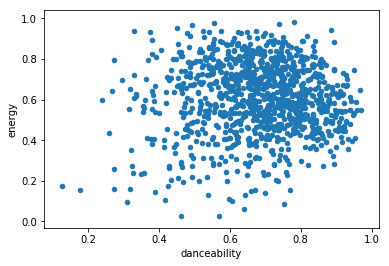

In [17]:
base.plot.scatter(x='danceability', y='energy')

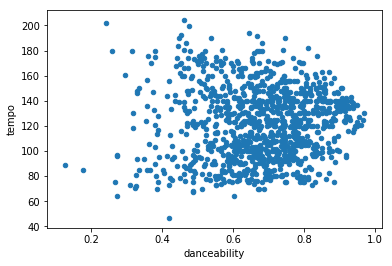

In [18]:
base.plot.scatter(x='danceability', y='tempo')

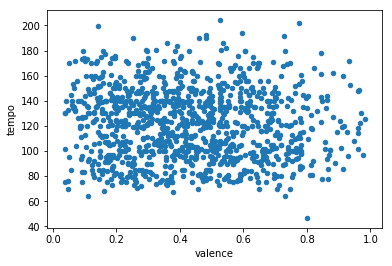

In [19]:
base.plot.scatter(x='valence', y='tempo')

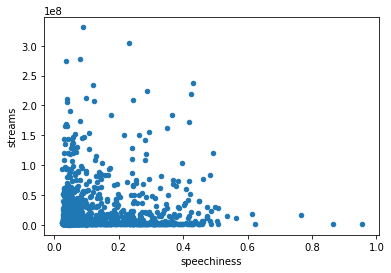

In [20]:
base.plot.scatter(x='speechiness', y='streams')

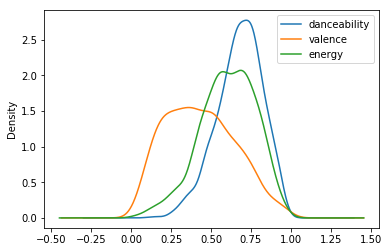

In [21]:
stuff = base[['danceability', 'valence', 'energy']]
stuff.plot.kde()